# Introduction

**My notebook for recognising handwritten digits from the MNIST dataset using a CNN with adaptive learning and callback function to maximise learning.** 

**Achieves a score 0.995 with 30 epochs - approx 5 min training time with GPU**

**1. Data pre-processing:**
* Loading data files
* Splitting data into train, validation, and test sets
* Reshaping dimensions of raw data

**2. Digit visualisation:**
* Function for plotting training data subfigures with true label

**3. Data Processing with Generators:**
* Train data generator: Augmentations and normalisation
* Validation data generator: Normalisation

**4. Defining the model:**
* Callback function
* Adaptive learning rate
* Model architecture
* Model compiling

**5. Training**
* Model Training and validation
* Plotting metrics change during training

**6. Testing**
* Using trained model to make predictions on the test set
* Exporting predictions as submission csv file


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop

# 1. Data pre-processing:

In [2]:
# Loading data
root = "../input/digit-recognizer/"
data = pd.read_csv(root + "train.csv")
test = pd.read_csv(root + "test.csv")
sample_submission = pd.read_csv(root + "sample_submission.csv")

# Partition the training and validation sets 
train_split = int(len(data)*0.9)
train = data[:train_split]
train_labels = train['label'].values.astype('float32')
train = train.drop('label', axis=1)
valid = data[train_split:]
valid_labels = valid['label'].values.astype('float32')
valid = valid.drop('label', axis=1)

# Reshaping the data to 28x28 images
len_train, len_valid, len_test = len(train), len(valid), len(test)
shape_train, shape_valid, shape_test = train.shape, valid.shape, test.shape
print("training: {}, validation: {}, testing: {}".format(len_train, len_valid, len_test))
print("dataset shapes; training: {}, validation: {}, testing: {}".format(shape_train, shape_valid, shape_test))

train_data = train.values.reshape(len_train, 28, 28, 1)
valid_data = valid.values.reshape(len_valid, 28, 28, 1)
test_data = test.values.reshape(len_test, 28, 28, 1)

reshape_train, reshape_valid, reshape_test = train_data.shape, valid_data.shape, test_data.shape
print("dataset dimensions after reshaping; training: {}, validation: {}, testing: {}".format(reshape_train, reshape_valid, reshape_test))

training: 37800, validation: 4200, testing: 28000
dataset shapes; training: (37800, 784), validation: (4200, 784), testing: (28000, 784)
dataset dimensions after reshaping; training: (37800, 28, 28, 1), validation: (4200, 28, 28, 1), testing: (28000, 28, 28, 1)


# **2. Digit visualisation:**

In [3]:
# Plots digits
def plot_digits(data, labels, num_images, columns=3):
    """ Plots MNIST digits in a subplot with the label of each being its title.

    Args:
        data: Matrix of dimensions [number of images, height, width, channels]
        labels: List of class labels.
        num_images: Number of images to be plotted
        columns: Number of columns to display in the figure.

    """
    images = data[:num_images]
    labels = labels[:num_images]
    rows = num_images // columns
    rows += num_images % columns
    position = range(1, num_images + 1)
    
    fig = plt.figure(figsize=(8,8))
    
    for n in range(num_images):
        ax = fig.add_subplot(rows, columns, position[n])
        ax.imshow(images[n][:, :, 0], cmap = 'Greys')
        ax.title.set_text(str(labels[n]))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.tight_layout()
    plt.show()

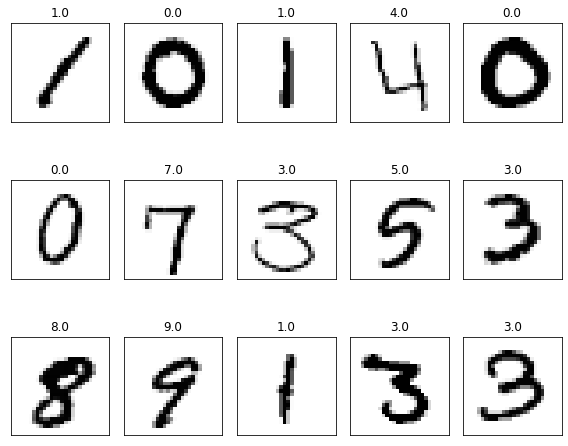

In [4]:
plot_digits(train_data, train_labels, 15, columns=5)

# 3. Data Processing with Generators:

In [5]:
# Passes train dataset through ImageDataGenerator with normalisation and augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=512)

# Passes valid dataset through ImageDataGenerator with normalisation 
valid_datagen = ImageDataGenerator(
    rescale=1./255)

valid_generator = valid_datagen.flow(
    valid_data,
    valid_labels,
    batch_size=512)

# 4. Defining the model:

In [6]:
# Model
# Creating a callback to end training before overfitting
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.998:
            print("Reached accuracy target, training stopped")
            self.model.stop_training = True
            
# Adaptive learning 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Defining the model
call_back = MyCallBack()
model = tf.keras.models.Sequential([
    # Fist Convolutional Layer
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Second Convolutional Layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Densely Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model and displaying architecture summary
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         5

# 5. Training

In [7]:
# Training
history = model.fit(train_generator, steps_per_epoch=len(train_data)/512, epochs=30, validation_data=(valid_generator), validation_steps=len(valid_data)/512, callbacks=[learning_rate_reduction, call_back])


Epoch 1/30
74/73 [==============================] - 13s 179ms/step - loss: 0.5696 - accuracy: 0.8446 - val_loss: 3.6758 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 2/30
74/73 [==============================] - 13s 180ms/step - loss: 0.1488 - accuracy: 0.9550 - val_loss: 4.4624 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 3/30
74/73 [==============================] - 14s 185ms/step - loss: 0.1092 - accuracy: 0.9663 - val_loss: 4.1521 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 4/30
74/73 [==============================] - 14s 186ms/step - loss: 0.0958 - accuracy: 0.9714 - val_loss: 3.1517 - val_accuracy: 0.1238 - lr: 0.0010
Epoch 5/30
74/73 [==============================] - 13s 175ms/step - loss: 0.0765 - accuracy: 0.9767 - val_loss: 1.4844 - val_accuracy: 0.3993 - lr: 0.0010
Epoch 6/30
74/73 [==============================] - 13s 179ms/step - loss: 0.0757 - accuracy: 0.9788 - val_loss: 0.8932 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 7/30
74/73 [==============================] - 14s 183ms/st

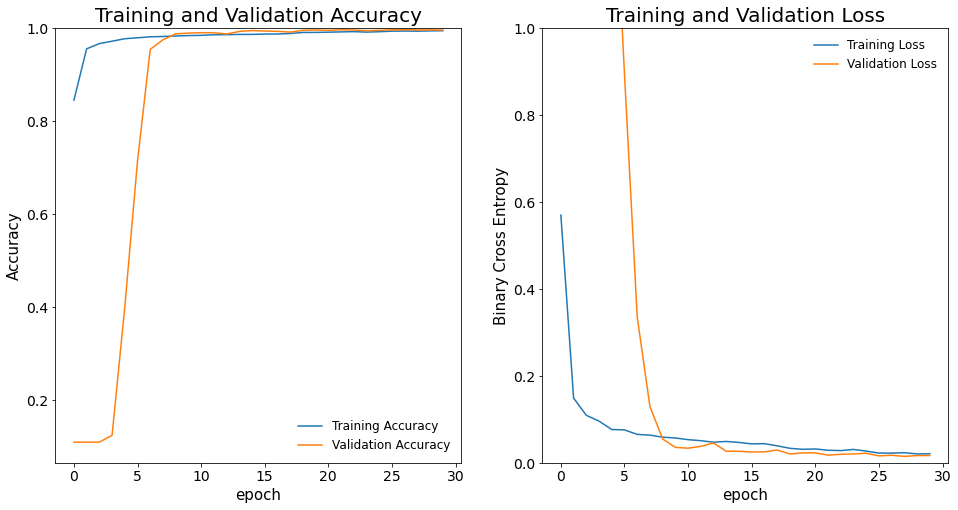

In [8]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right', frameon=False, fontsize=12)
plt.ylabel('Accuracy', fontsize= 15)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize= 20)
plt.xlabel('epoch', fontsize= 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right', frameon=False, fontsize=12)
plt.ylabel('Binary Cross Entropy', fontsize= 15)
plt.ylim([0,1.0])
plt.title('Training and Validation Loss', fontsize= 20)
plt.xlabel('epoch', fontsize= 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# 6. Testing

In [9]:
# Making predictions on the test set
test_data = test_data/255
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
sample_submission['Label'] = predictions

#Output predictions as csv for competition submission
sample_submission.to_csv("output.csv", index=False)

**Achieves a score 0.995 with 30 epochs - approx 5 min training time with GPU**